Comp 4447 Final Project
Predict Box Office Opening Weekend Revenue
By: Arisbeth Laguna, Dan Jung and Matt Ostendorf

Import Libraries

In [438]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split , RandomizedSearchCV, cross_val_predict, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

Create Random State Variable

In [439]:
rand_state = 425

Read in data files to dataframes

In [440]:
movie_data = pd.read_csv('OMDB API Data.csv')
CPI_data = pd.read_csv('CPI Data.csv')


Display few rows of movie data

In [441]:
pd.set_option('display.max_columns', None)
movie_data.head(5)

,imdbID,TT URL,Opening Revenue,RL URL,Number of Theaters,tmdbID,url,budget,original_title,title,overview,production_company,belongs_to_collection,omdb title,year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings_IMDB,Ratings_Rotten,Ratings_Metacritic,Metascore,imdbRating,imdbVotes,Type,DVD,BoxOffice,Production,Website,Response
0,tt0338751,https://www.boxofficemojo.com/title/tt00338751/?ref_=bo_se_r_1,"$858,021",https://www.boxofficemojo.com/release/rl742753793/weekend?ref_=bo_tt_gr#table,40,2567,https://api.themoviedb.org/3/movie/2567?api_key=448fb8084e6c46cb8447cda0cd773e3a,110000000.0,The Aviator,The Aviator,"A biopic depicting the life of filmmaker and aviation pioneer Howard Hughes from 1927 to 1947, during which time he became a successful film producer and an aviation magnate, while simultaneously growing more unstable due to severe obsessive-compulsive disorder.","[{'id': 14, 'logo_path': '/m6AHu84oZQxvq7n1rsvMNJIAsMu.png', 'name': 'Miramax', 'origin_country': 'US'}, {'id': 562, 'logo_path': '/azANEzu3H3Kztzt63sdjvlzxhuB.png', 'name': 'Appian Way', 'origin_country': 'US'}, {'id': 675, 'logo_path': None, 'name': 'Forward Pass', 'origin_country': 'US'}, {'id': 7380, 'logo_path': None, 'name': 'Initial Entertainment Group', 'origin_country': 'US'}, {'id': 19116, 'logo_path': None, 'name': 'IMF Internationale Medien und Film GmbH & Co. 3. Produktions KG', 'origin_country': 'DE'}, {'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOIDdWRKSEJ.png', 'name': 'Warner Bros. Pictures', 'origin_country': 'US'}]",None,The Aviator,2004.0,PG-13,12/25/2004,170 min,"Biography, Drama",Martin Scorsese,John Logan,"Leonardo DiCaprio, Cate Blanchett, Kate Beckinsale",A biopic depicting the early years of legendary director and aviator Howard Hughes' career from the late 1920s to the mid 1940s.,"English, Persian","United States, Germany",Won 5 Oscars. 89 wins &amp; 131 nominations total,https://m.media-amazon.com/images/M/MV5BZTYzMjA2M2EtYmY1OC00ZWMxLThlY2YtZGI3MTQzOWM4YjE3XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_SX300.jpg,7.5/10,86%,77/100,77.0,7.5,"376,165",movie,19-Apr-16,"$102,610,330",NaN,NaN,True
1,tt0293508,https://www.boxofficemojo.com/title/tt00293508/?ref_=bo_se_r_1,"$4,001,890",https://www.boxofficemojo.com/release/rl1214809601/weekend?ref_=bo_tt_gr#table,622,9833,https://api.themoviedb.org/3/movie/9833?api_key=448fb8084e6c46cb8447cda0cd773e3a,70000000.0,The Phantom of the Opera,The Phantom of the Opera,"Deformed since birth, a bitter man known only as the Phantom lives in the sewers underneath the Paris Opera House. He falls in love with the obscure chorus singer Christine, and privately tutors her while terrorizing the rest of the opera house and demanding Christine be given lead roles.","[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOIDdWRKSEJ.png', 'name': 'Warner Bros. Pictures', 'origin_country': 'US'}, {'id': 3539, 'logo_path': None, 'name': 'Odyssey Entertainment', 'origin_country': 'GB'}, {'id': 7419, 'logo_path': '/gz5Kdc138DEz93LvcppdBPuW1jV.png', 'name': 'Scion Films', 'origin_country': 'GB'}, {'id': 7922, 'logo_path': '/kWdopfnceXhS3RRkU5ktd7J3nXx.png', 'name': 'The Really Useful Group', 'origin_country': 'GB'}]",None,The Phantom of the Opera,2004.0,PG-13,1/21/2005,143 min,"Drama, Musical, Romance",Joel Schumacher,"Gaston Leroux, Andrew Lloyd Webber, Joel Schumacher","Gerard Butler, Emmy Rossum, Patrick Wilson",A young soprano becomes the obsession of a disfigured and murderous musical genius who lives beneath the Paris Opéra House.,"English, Italian","United Kingdom, United States",Nominated for 3 Oscars. 7 wins &amp; 42 nominations total,https://m.media-amazon.com/images/M/MV5BNDczNzg4OTM3MV5BMl5BanBnXkFtZTcwOTQzMTEzMw@@._V1_SX300.jpg,7.2/10,33%,40/100,40.0,7.2,"128,266",movie,27-Dec-11,"$51,293,931",NaN,NaN,True
2,tt0363473,https://www.boxofficemojo.com/title/tt00363473/?ref_=bo_se_r_1,"$45,264",https://www.boxofficemojo.com/release/rl3326379521/weekend?ref_=bo_tt_gr#table,6,6478,https://

In [442]:
#Dropping duplicate rows
movie_data.drop(['imdbRating', 'Metascore'], axis=1, inplace=True)

Display a few rows of CPI data

In [443]:
CPI_data.head(5)

,Year,1,2,3,4,5,6,7,8,9,10,11,12,HALF1,HALF2
0,1913,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,NaN,NaN
1,1914,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,NaN,NaN
2,1915,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3,NaN,NaN
3,1916,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6,NaN,NaN
4,1917,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7,NaN,NaN


Review the types of data in movie data

In [444]:
print(movie_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13005 entries, 0 to 13004
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdbID                 13005 non-null  object 
 1   TT URL                 13005 non-null  object 
 2   Opening Revenue        13005 non-null  object 
 3   RL URL                 13005 non-null  object 
 4   Number of Theaters     13005 non-null  object 
 5   tmdbID                 13005 non-null  int64  
 6   url                    13005 non-null  object 
 7   budget                 12973 non-null  float64
 8   original_title         12973 non-null  object 
 9   title                  12973 non-null  object 
 10  overview               12972 non-null  object 
 11  production_company     13005 non-null  object 
 12  belongs_to_collection  13005 non-null  object 
 13  omdb title             12999 non-null  object 
 14  year                   12999 non-null  float64
 15  Ra

In [445]:
#Look for null values
movie_data.isnull().sum()

imdbID                   0    
TT URL                   0    
Opening Revenue          0    
RL URL                   0    
Number of Theaters       0    
tmdbID                   0    
url                      0    
budget                   32   
original_title           32   
title                    32   
overview                 33   
production_company       0    
belongs_to_collection    0    
omdb title               6    
year                     6    
Rated                    616  
Released                 64   
Runtime                  25   
Genre                    24   
Director                 33   
Writer                   572  
Actors                   83   
Plot                     27   
Language                 37   
Country                  24   
Awards                   2133 
Poster                   24   
Ratings_IMDB             26   
Ratings_Rotten           1032 
Ratings_Metacritic       2606 
imdbVotes                24   
Type                     6    
DVD     

THe columns Writers, Awards, DVD, Production and Website are missing a lot of values. We will remove them from our analysis

In [446]:
movie_data.drop(['Writer','Awards', 'DVD','Production', 'Website'], axis=1, inplace=True)

Need to change the columns Opening Revenue, Number of Theaters, Runtime, Ratings_IMDB, Ratings_Rotten and Ratings_Metacritic to be the correct data type

In [447]:
#Need to remove dollar signs and commas and make integers from opening revenue
movie_data['Opening Revenue'].head(5)

0    $858,021   
1    $4,001,890 
2    $45,264    
3    $53,985    
4    $151,750   
Name: Opening Revenue, dtype: object

In [448]:
movie_data['Opening Revenue'] = movie_data['Opening Revenue'].str.replace('[$,]', '', regex=True).astype(float)

In [449]:
#Need to change number of theaters to int
movie_data['Number of Theaters'] = movie_data['Number of Theaters'].str.replace('[,]', '', regex=True).astype(int)

In [450]:
#Change runtime to float
movie_data['Runtime'].head(5)

0    170 min
1    143 min
2    118 min
3    87 min 
4    109 min
Name: Runtime, dtype: object

In [451]:
movie_data['Runtime'] = movie_data['Runtime'].str.replace('min', '', regex=True).astype(float)

In [452]:
#Convert Ratings_IMDB to float
movie_data['Ratings_IMDB'].head(5)

0    7.5/10
1    7.2/10
2    6.7/10
3    7.2/10
4    6.5/10
Name: Ratings_IMDB, dtype: object

In [453]:
#Converts IMDB rating to a percentage
def fix_IMDB_ratings(row):
    if pd.notna(row['Ratings_IMDB']): 
        return round(float(row['Ratings_IMDB'].split('/')[0])*10/100,4)
    
movie_data['Ratings_IMDB'] = movie_data.apply(fix_IMDB_ratings, axis=1)

In [454]:
#Convert Ratings_Rotten to float
movie_data['Ratings_Rotten'].head(5)

0    86%
1    33%
2    42%
3    88%
4    82%
Name: Ratings_Rotten, dtype: object

In [455]:
movie_data['Ratings_Rotten'] = movie_data['Ratings_Rotten'].str.replace('%', '', regex=True).astype(float)

In [456]:
#Now need to divide by 100 to get into decimal format
movie_data['Ratings_Rotten'] = movie_data['Ratings_Rotten'] /100

In [457]:
#Change meta critic to float
movie_data['Ratings_Metacritic'].head(5)

0    77/100
1    40/100
2    46/100
3    72/100
4    66/100
Name: Ratings_Metacritic, dtype: object

In [458]:
#Can use same logic as IMDB to get in float format
def fix_META_ratings(row):
    if pd.notna(row['Ratings_Metacritic']): 
        return round(float(row['Ratings_Metacritic'].split('/')[0])*10/100,4)
movie_data['Ratings_Metacritic'] = movie_data.apply(fix_META_ratings, axis=1)

Since the movies are all from different years we need to change the revenue to today's dollars. We will use the CPI to do this. Will need to split out month and year into different fields. Then apply the formula Opening Weekend Revenue x ending period CPI / Beginning period CPI 

In [459]:
#Create month field
def get_month(row):
    if pd.notna(row['Released']): 
        return int(row['Released'].split('/')[0])
movie_data['Month'] = movie_data.apply(get_month, axis=1)


In [460]:
#Create Year field
def get_year(row):
    if pd.notna(row['Released']): 
        return int(row['Released'].split('/')[2])
movie_data['Released Year'] = movie_data.apply(get_year, axis=1)


In [461]:
movie_data['Ending CPI'] = CPI_data['9'].max()

def get_Beg_CPI(row):
    for indexs, rows in CPI_data.iterrows():
        if rows['Year'] == row['Released Year']:
            return rows[int(row['Month'])]

movie_data['Beg CPI'] = movie_data.apply(get_Beg_CPI, axis=1)

In [462]:
#Adjusted Revenue
movie_data['Adjusted Opening Weekend Revenue'] = movie_data['Opening Revenue'] * movie_data['Ending CPI'] / movie_data['Beg CPI']

In [463]:
#Drop CPI values as not need any more along with opening revenue since we have calculated the correct value for it
movie_data.drop(['Ending CPI' ,'Beg CPI', 'Opening Revenue'], axis=1, inplace=True)

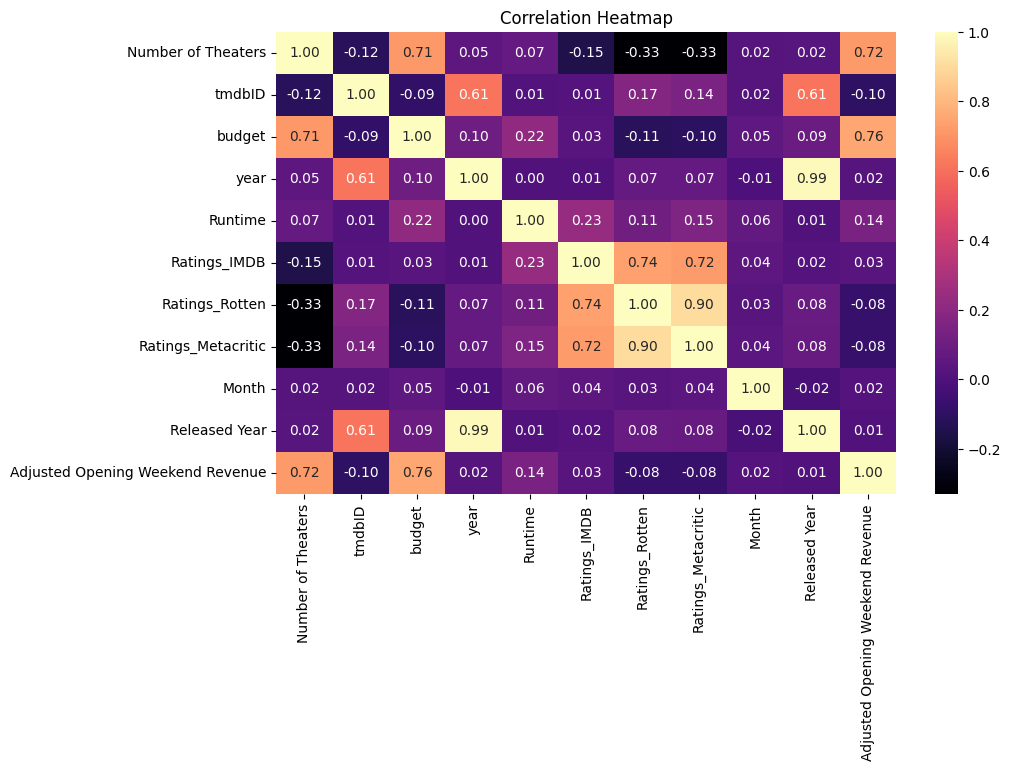

In [464]:
correlation_matrix = movie_data.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap= 'magma', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

We see a high correlation between the 3 rating systems (IMDB, Rotten Tomatoes and Metacritic). IMDB has the most valid rows. Therefore we will drop the other two from the dataframe

In [465]:
movie_data.drop(['Ratings_Rotten', 'Ratings_Metacritic'], axis=1, inplace=True)

<Axes: >

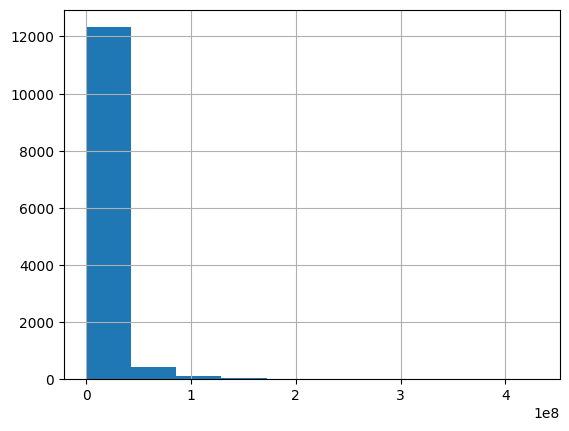

In [466]:
movie_data['Adjusted Opening Weekend Revenue'].hist()

Review dataframe for null values

In [467]:
movie_data.isna().sum()

imdbID                              0  
TT URL                              0  
RL URL                              0  
Number of Theaters                  0  
tmdbID                              0  
url                                 0  
budget                              32 
original_title                      32 
title                               32 
overview                            33 
production_company                  0  
belongs_to_collection               0  
omdb title                          6  
year                                6  
Rated                               616
Released                            64 
Runtime                             25 
Genre                               24 
Director                            33 
Actors                              83 
Plot                                27 
Language                            37 
Country                             24 
Poster                              24 
Ratings_IMDB                        26 


The column Rated has 616 missing values. We will drop Those rows and see how many missing values we have after.

In [468]:
movie_data.dropna(inplace=True)

In [469]:
movie_data.isna().sum()

imdbID                              0
TT URL                              0
RL URL                              0
Number of Theaters                  0
tmdbID                              0
url                                 0
budget                              0
original_title                      0
title                               0
overview                            0
production_company                  0
belongs_to_collection               0
omdb title                          0
year                                0
Rated                               0
Released                            0
Runtime                             0
Genre                               0
Director                            0
Actors                              0
Plot                                0
Language                            0
Country                             0
Poster                              0
Ratings_IMDB                        0
imdbVotes                           0
Type        

In [470]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12269 entries, 0 to 13004
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   imdbID                            12269 non-null  object 
 1   TT URL                            12269 non-null  object 
 2   RL URL                            12269 non-null  object 
 3   Number of Theaters                12269 non-null  int32  
 4   tmdbID                            12269 non-null  int64  
 5   url                               12269 non-null  object 
 6   budget                            12269 non-null  float64
 7   original_title                    12269 non-null  object 
 8   title                             12269 non-null  object 
 9   overview                          12269 non-null  object 
 10  production_company                12269 non-null  object 
 11  belongs_to_collection             12269 non-null  object 
 12  omdb

In [471]:
#Make year and month be type integer
movie_data['Released Year'] = movie_data['Released Year'].astype(int)
movie_data['Month'] = movie_data['Month'].astype(int)

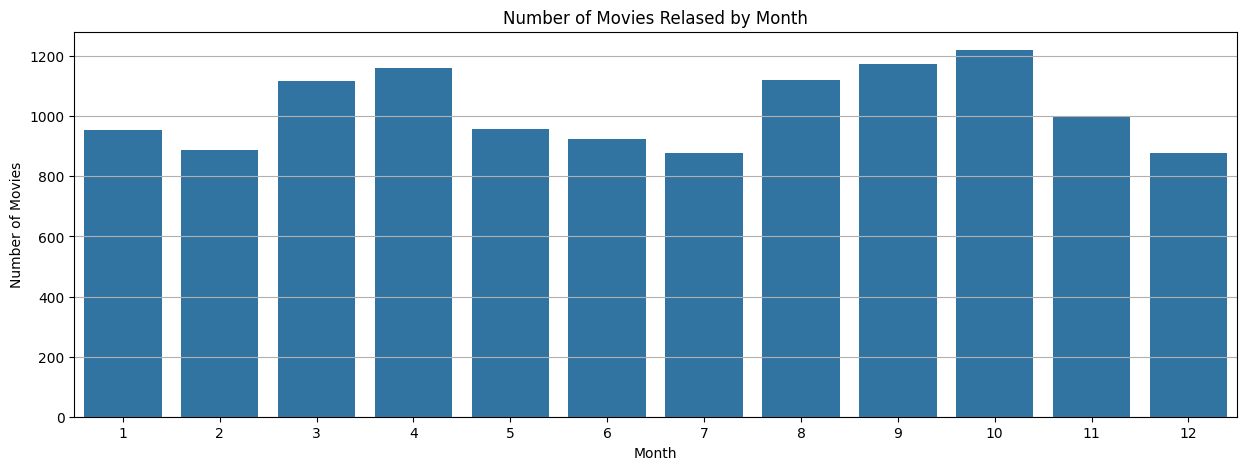

In [472]:
plt.figure(figsize = (15,5))
sns.barplot(x='Month', y='Month', data=movie_data, errorbar = None, estimator = 'count')
plt.title('Number of Movies Relased by Month')
plt.grid(axis='y')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.show()

Based on the bar graph above we notice the May, June, July and December have the least amount of movies released historically. Where September and October have the most. 

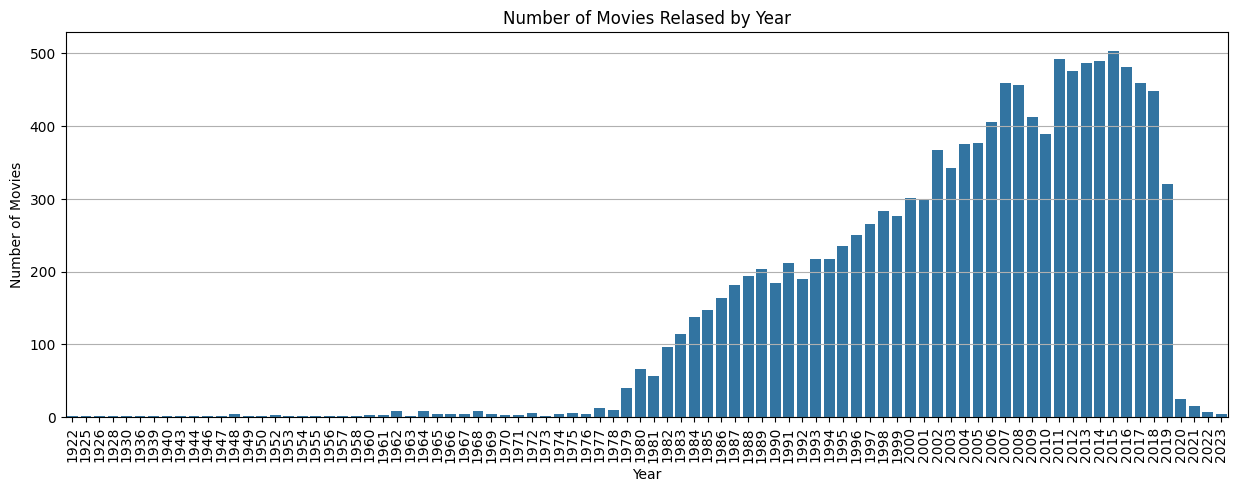

In [473]:
plt.figure(figsize = (15,5))
sns.barplot(x='Released Year', y='Released Year', data=movie_data, errorbar = None, estimator = 'count')
plt.title('Number of Movies Relased by Year')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

As time has gone on we have seen an increase in the number of movies released each year

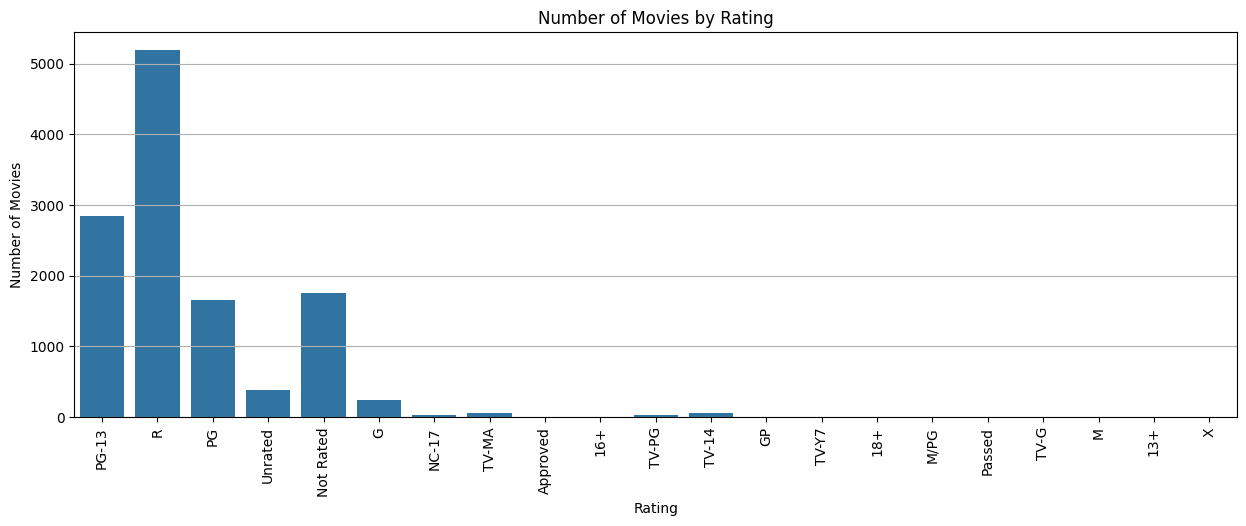

In [474]:
plt.figure(figsize = (15,5))
sns.barplot(x='Rated', y='Released Year', data=movie_data, errorbar = None, estimator = 'count')
plt.title('Number of Movies by Rating')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.show()

In [475]:
#Dropping unneeded columns
movie_data_final = pd.DataFrame(movie_data.drop(columns=['imdbID', 'original_title', 'TT URL', 'RL URL' , 'tmdbID', 'url', 'title', 'overview', 'production_company','belongs_to_collection'
                         ,'omdb title','year','Released', 'Plot', 'Poster', 'imdbVotes', 'Type', 'BoxOffice', 'Response']).copy())

Dummy code categorical variables

In [476]:
movie_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12269 entries, 0 to 13004
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Number of Theaters                12269 non-null  int32  
 1   budget                            12269 non-null  float64
 2   Rated                             12269 non-null  object 
 3   Runtime                           12269 non-null  float64
 4   Genre                             12269 non-null  object 
 5   Director                          12269 non-null  object 
 6   Actors                            12269 non-null  object 
 7   Language                          12269 non-null  object 
 8   Country                           12269 non-null  object 
 9   Ratings_IMDB                      12269 non-null  float64
 10  Month                             12269 non-null  int32  
 11  Released Year                     12269 non-null  int32  
 12  Adju

In [477]:
#reducing dimensionality
movie_data_final.drop(['Genre', 'Director', 'Actors', 'Language','Country'], axis=1, inplace=True)


In [479]:
movie_data_final = pd.get_dummies(movie_data_final, columns=['Rated'])

Do train test split. We will do 80/20 split of data

In [480]:
df_x = pd.DataFrame(movie_data_final.drop(columns='Adjusted Opening Weekend Revenue').copy())
df_y= pd.DataFrame(movie_data_final['Adjusted Opening Weekend Revenue'])

X_train, X_test,y_train,y_test = train_test_split(df_x ,df_y, test_size= 0.20, random_state= rand_state)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9815, 27)
(2454, 27)
(9815, 1)
(2454, 1)


In [481]:
#Create output dataframe
column_names = ['Model Type' ,'R^2', 'MSE', 'RMSE']
df_models = pd.DataFrame(columns=column_names)

In [482]:
all_models = [DecisionTreeRegressor(random_state = rand_state), RandomForestRegressor( random_state = rand_state)]

In [483]:
output = []
for curr_model in all_models:
    print(curr_model)
    curr_model.fit(X_train,y_train)
    preds_dummy = curr_model.predict(X_train)
    r2_scores = cross_val_score(curr_model, X_train, y_train, cv=10, scoring='r2').mean()
    mse = cross_val_score(estimator= curr_model, X= X_train, y= y_train, cv= 10, scoring= 'neg_mean_squared_error')
    mse_mean = mse.mean()
    rmse = np.sqrt(-mse_mean)
    rmse_mean = rmse.mean()
    output += [curr_model, r2_scores, mse, rmse]

df_models = output


DecisionTreeRegressor(random_state=425)
RandomForestRegressor(random_state=425)


C:\Users\mcogb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mcogb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mcogb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

KeyboardInterrupt: 

In [433]:
df_models

[DecisionTreeRegressor(random_state=425),
 0.6514979642092895,
 array([-1.25198697e+14, -2.04975228e+14, -1.36104523e+14, -1.27079143e+14,
        -1.37584923e+14, -2.05699728e+14, -1.38125634e+14, -1.22080512e+14,
        -1.51679339e+14, -1.90918289e+14]),
 12407441.376226477,
 RandomForestRegressor(random_state=425),
 0.808812803430141,
 array([-7.55314396e+13, -1.31526472e+14, -8.39837003e+13, -6.93015452e+13,
        -6.26187163e+13, -1.34005238e+14, -5.89720164e+13, -8.02354293e+13,
        -6.49843531e+13, -1.10846013e+14]),
 9338120.387371577]